In [24]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"
con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [25]:
import pandas as pd
import numpy as np


def get_data():
    df = pd.read_sql_query("SELECT * FROM ACGRWide", con)

    df.replace('*', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    df.fillna(df.mean(), inplace=True)
    df.fillna(0, inplace=True)
    return df

def get_data_xgb():
    # This function is used for XGBoost training without removing missing values
    df = pd.read_sql_query("SELECT * FROM ACGRWide", con)

    df.replace('*', np.nan, inplace=True)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(axis=1, how='all', inplace=True)
    return df

df = get_data()


### Data Summary

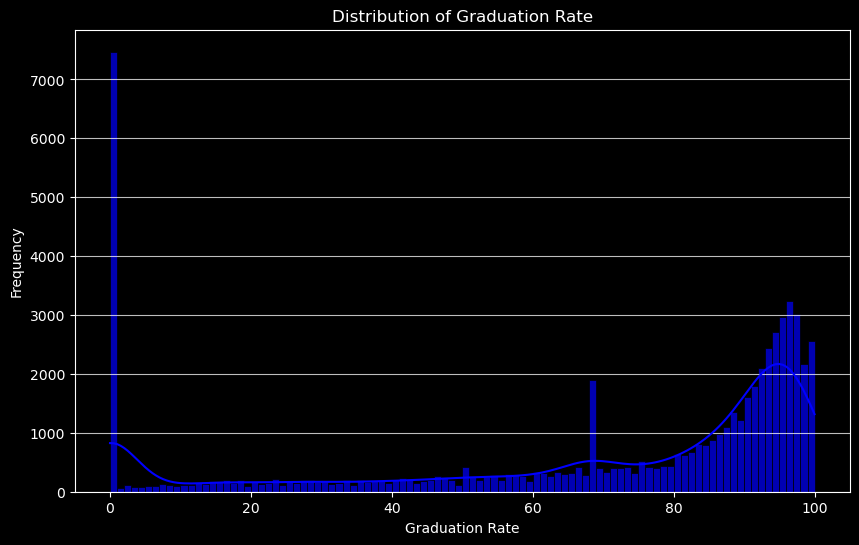

Mean Graduation Rate: 68.04490446940648


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['RegHSDiplomaRate.TA'].dropna(), bins=100, kde=True, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Graduation Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Graduation Rate")
plt.grid(axis='y', alpha=0.75)
plt.show()


mean_graduation_rate = df['RegHSDiplomaRate.TA'].mean()
print(f"Mean Graduation Rate: {mean_graduation_rate}")  

# Lasso Models

## Graduation Rate as Target Variable

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6768.930203242227, tolerance: 5794.590868667699
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37738.99652931839, tolerance: 5794.590868667699
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8226.525529420003, tolerance: 5731.901515734487
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py


CPPRate.SS: 88.92077277306593
CohortStudents.GF: -26.618906981949916
UniReqs.SS: 15.46458591288698
UniReqs.GF: -15.39529606193666
UniReqs.GM: -12.513939489950738
CohortStudents.GM: -11.011438266650744
CPPRate.SE: 7.806633585388911
CPPRate.RW: -7.577725498058088
CohortStudents.RA: -7.461897170777792
UniReqsPercent.RT: -7.053914433435398
Other.GM: -6.389496491258281
CPPRate.RP: -6.008407572502753
Merit.SS: 5.362061401794449
UniReqsPercent.RF: -5.331171557631083
CPPRate.SD: -5.175547742033809
Dropout.SS: -5.129357209196398
StillEnrolledRate.RP: 4.985413915541887
UniReqs.RA: 4.972315882373864
UniReqsPercent.GF: 4.773483147715621
Dropout.GM: -3.551791993314712
StillEnrolledRate.RW: 3.427128470608533
Other.SS: -3.4024615261582785
UniReqsPercent.SE: 3.3641737736541057
CohortStudents.RB: -2.688153641531325
Other.GF: -2.6666400044292162
StillEnrolledRate.SE: -2.6134689660994406
UniReqs.SE: -2.611344075963683
DistrictCode: 2.604317644011488
StillEnrolledRate.RT: -2.585062947788649
Dropout.GF: -

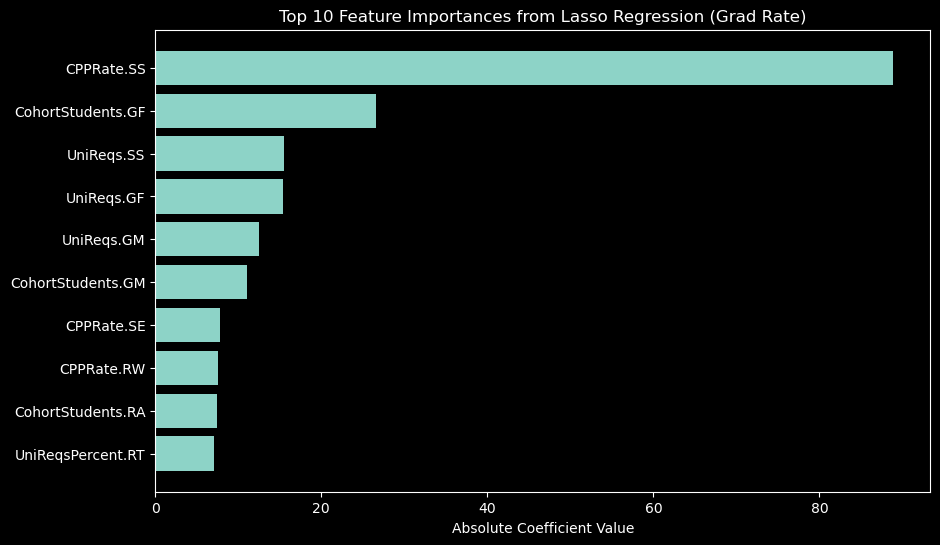

In [27]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline

target_column = "RegHSDiplomaRate.TA"

X = df.drop(columns=[target_column])
y = df[target_column]

# Remove all features that begin with RegHSDiploma
X = X.loc[:, ~X.columns.str.startswith('RegHSDiploma')]

# Drop rows where y is NaN
mask = y.notna()
X = X[mask]
y = y[mask]

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000)) 
])

# Fit the model
pipe.fit(X_reduced, y)

# Get the coefficients of the Lasso model
lasso_coefficients = pipe['lasso'].coef_

coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot top 10 feature importances
top_n = 10
top_features = sorted_pairs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [abs(f[1]) for f in top_features])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances from Lasso Regression (Grad Rate)")
plt.gca().invert_yaxis()
plt.show()

### Graduation Rate Model Validation (DID NOT CONVERGE)

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)

print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16585.490750487894, tolerance: 4515.835484366263
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19901.854733379558, tolerance: 4507.806935701562
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10266.792096009478, tolerance: 4500.466865944584
  model = cd_fast.enet_coordinate_descent_gram(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent

R^2 Score: 0.7306160551373847
Mean Squared Error: 314.68608480669303
Root Mean Squared Error: 17.73939358621633
Best alpha value: 0.021566167707015922


### Graduation Rate Residuals

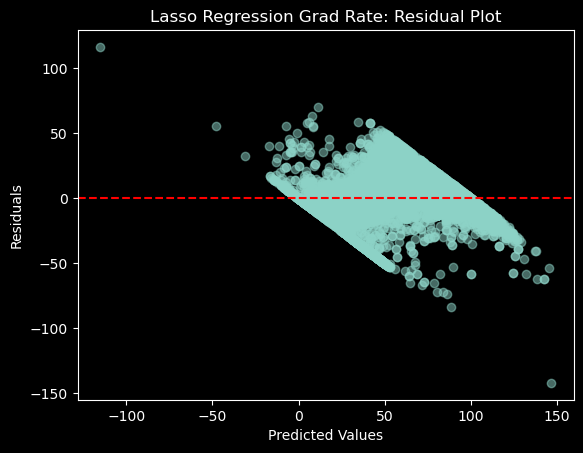

In [29]:
y_test_numeric = pd.to_numeric(y_test, errors='coerce')

# Calculate residuals
residuals = y_test_numeric - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression Grad Rate: Residual Plot")
plt.show()

### Graduation Rate Actual vs. Predicted

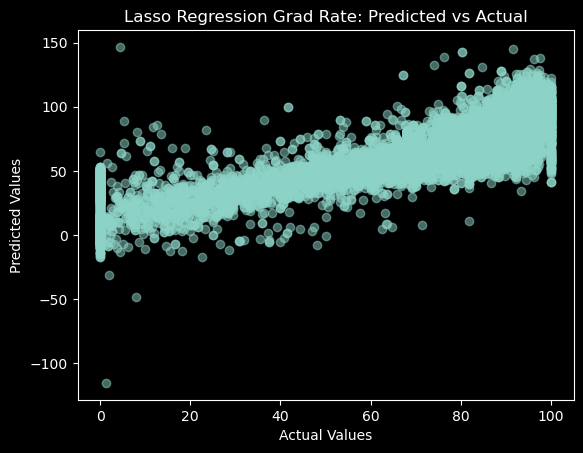

In [30]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Grad Rate: Predicted vs Actual")
plt.show()

## CSU/UC Readiness as Target Variable



AdultEd.SS: 17.62460743381324
Other.SS: 9.050125254773604
UniReqsPercent.GF: 8.26017122382936
SPED.SS: 7.920894716029777
UniReqsPercent.GM: 5.35827428398952
SPED.SE: -5.3301717264193
Other.SE: -3.832501508005206
CPP.SS: 3.4503038125517835
MeritRate.GF: -3.2148099765852955
AdultEd.RW: 1.843380295635701
CPP.SE: -1.6079472487867565
MeritRate.GM: -1.5556787119803643
UniReqsPercent.SE: -1.5278969543827108
UniReqsPercent.SS: 1.5233488311307548
RegHSDiplomaRate.GF: -1.2777106431340757
RegHSDiplomaRate.GM: -1.2621856438505359
BiliteracyRate.GF: -1.1574931870178375
UniReqs.GF: -0.7802878786868941
Other.RT: -0.7734697418945478
RegHSDiplomaRate.SS: 0.6138241420865032
BiliteracyRate.GM: -0.604506345295728
SPED.RT: -0.568142147530265
RegHSDiplomaRate.RT: 0.41219311127442626
GED.SS: 0.27440710873877083
GED.SE: -0.22392654803983697
UniReqsPercent.RW: -0.17470563833840005
MeritRate.SE: 0.15531046326529696
Merit.SS: -0.1462827513152875
RegHSDiploma.RH: -0.13976289608287412
Other.RA: 0.1377966433865821

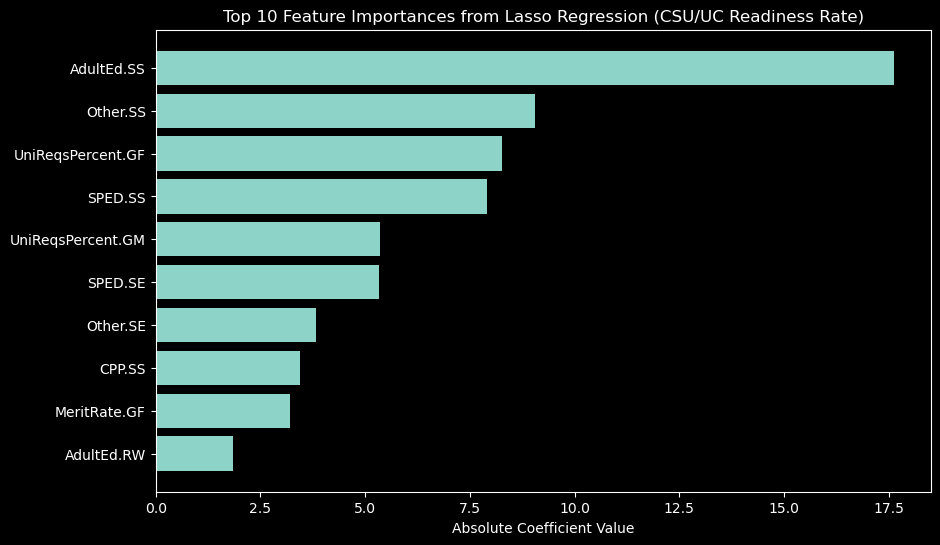

In [32]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

target_column = "UniReqsPercent.TA"

# Reset df
df = get_data()

# Remove all features that begin with UniReqs
X = df.drop(columns=[col for col in df.columns if col.startswith('UniReqs')])


X = df.drop(columns=[target_column])
y = df[target_column]

# Setup Model
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42, max_iter=10000)) 
])

# Fit the model
pipe.fit(X_reduced, y)

lasso_coefficients = pipe['lasso'].coef_


coef_feature_pairs = list(zip(X.columns, lasso_coefficients))
sorted_pairs = sorted(coef_feature_pairs, key=lambda x: abs(x[1]), reverse=True)
print()
for feature, coef in sorted_pairs:
    print(f"{feature}: {coef}")

# Plot top 10 feature importances
top_n = 10
top_features = sorted_pairs[:top_n]

plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in top_features], [abs(f[1]) for f in top_features])
plt.xlabel("Absolute Coefficient Value")
plt.title("Top 10 Feature Importances from Lasso Regression (CSU/UC Readiness Rate)")
plt.gca().invert_yaxis()
plt.show()

### CSU/UC Readiness Model Validation

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train, y_train)

# Make predictions
y_pred = pipe.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_2 = pipe.score(X_test, y_test)

print(f"R^2 Score: {r_2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Best alpha value: {pipe['lasso'].alpha_}")

R^2 Score: 0.9797288869432308
Mean Squared Error: 20.027573113489904
Root Mean Squared Error: 4.475217661018277
Best alpha value: 0.030642728172816422


### CSU/UC Readiness Residuals


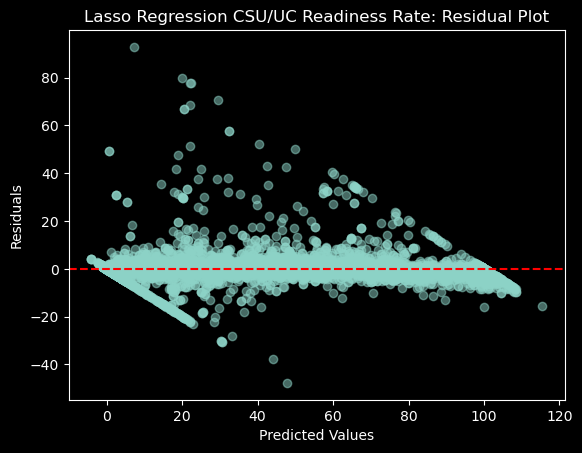

In [34]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Lasso Regression CSU/UC Readiness Rate: Residual Plot")
plt.show()

### CSU/UC Readiness Actual vs. Predicted

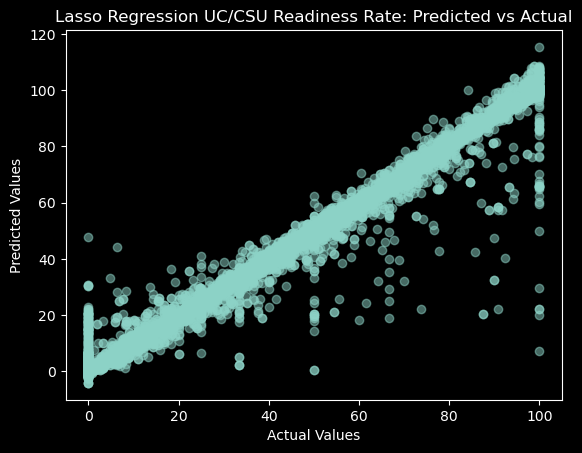

In [35]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression UC/CSU Readiness Rate: Predicted vs Actual")
plt.show()

# XGBoost Models

## CSU/UC Readiness as Target

Feature ranking:
1. RegHSDiplomaRate.GF (0.12097621709108353)
2. RegHSDiplomaRate.TA (0.11491493135690689)
3. MeritRate.TA (0.06742700189352036)
4. Merit.TA (0.0237420666962862)
5. CPPRate.SH (0.020892946049571037)
6. BiliteracyRate.TA (0.012712264433503151)
7. Biliteracy.TA (0.012359668500721455)
8. CPP.SM (0.012052234262228012)
9. Other.RD (0.011711886152625084)
10. GEDRate.SM (0.010047280229628086)
11. RegHSDiploma.GF (0.009957142174243927)
12. RegHSDiploma.RW (0.009933186694979668)
13. MeritRate.GM (0.009411034174263477)
14. RegHSDiploma.RH (0.008811400271952152)
15. BiliteracyRate.SH (0.008647897280752659)
16. AdultEdRate.SH (0.007929335348308086)
17. BiliteracyRate.RW (0.007451907265931368)
18. GED.SM (0.007124790456146002)
19. RegHSDiploma.RA (0.006936674937605858)
20. AdultEdRate.SM (0.006682479288429022)
21. BiliteracyRate.SS (0.006628636736422777)
22. MeritRate.SS (0.006539692636579275)
23. RegHSDiplomaRate.GM (0.006478729657828808)
24. Biliteracy.SM (0.006342312321066856)
25

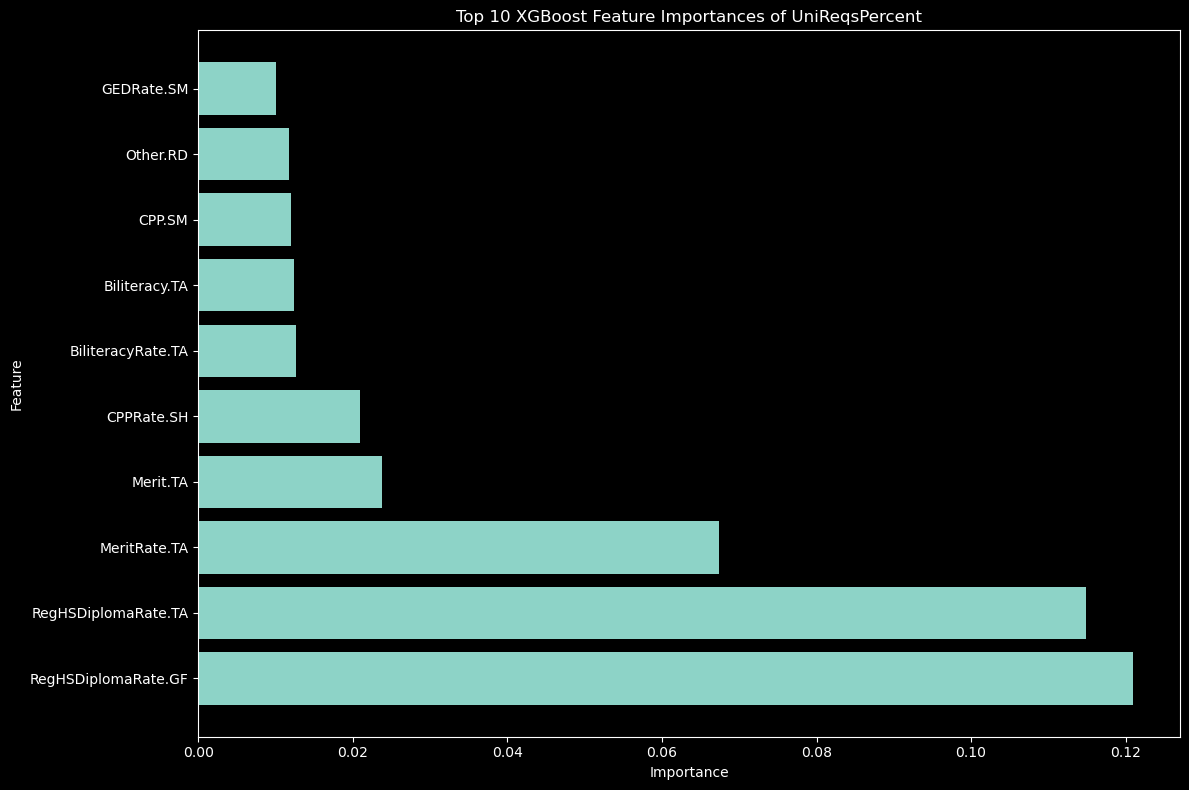

In [38]:
import xgboost as xgb

target_col = 'UniReqsPercent.TA'

# Reset df
df = get_data_xgb()

# Drop columns that start with 'UniReqs'
X = df.drop(columns=[col for col in df.columns if col.startswith('UniReqs')])

# Remove rows where y is NaN or infinite or too large
mask = y.notna() & np.isfinite(y) & (np.abs(y) < 1e10)
X = X[mask]
y = y[mask]

# XGBoost for UniReqsPercent as target variable
xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

# Fit the model
xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]
print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot top 10 feature importances for UniReqsPercent
top_n = 10
top_indices = indices_uni[:top_n]
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importances_uni[top_indices], align='center')
plt.yticks(range(top_n), feature_names_uni[top_indices])
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.title("Top 10 XGBoost Feature Importances of UniReqsPercent")
plt.tight_layout()
plt.show()

### Model Validation

In [39]:
# Split the data into training and testing sets
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 139.22620525044667
Root Mean Squared Error: 11.79941546223569
Mean Absolute Error: 7.183301890094656
R^2 Score: 0.8590807717388497


### Residuals

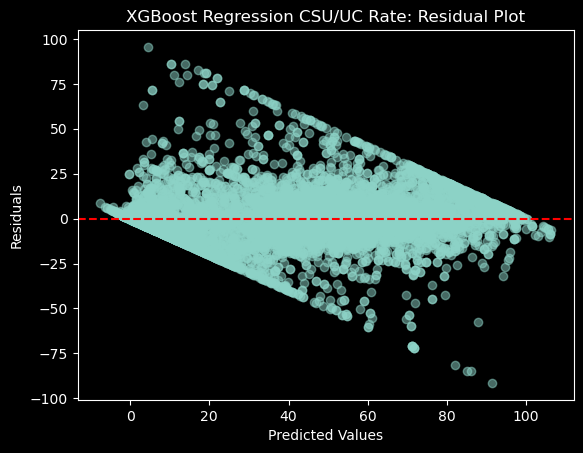

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression CSU/UC Rate: Residual Plot")
plt.show()

### Actual vs. Predicted

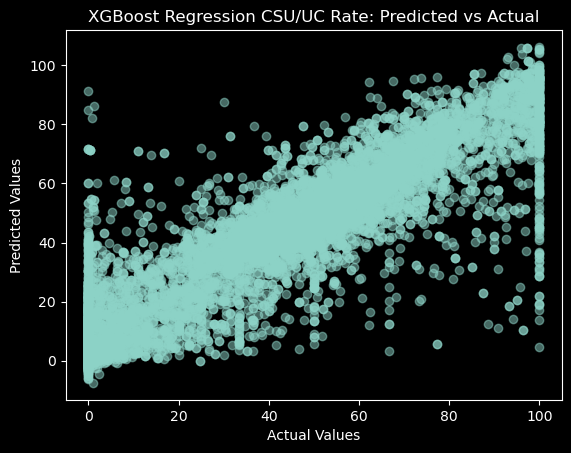

In [41]:
# Plot actual vs. predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression CSU/UC Rate: Predicted vs Actual")
plt.show()

## Graduation Rate as Target

Feature ranking:
1. UniReqsPercent.TA (0.6670498847961426)
2. UniReqsPercent.SS (0.2133508026599884)
3. UniReqs.TA (0.04368819668889046)
4. UniReqsPercent.GM (0.0370265357196331)
5. UniReqsPercent.GF (0.014291761443018913)
6. CohortStudents.SS (0.006560214329510927)
7. Dropout.TA (0.003970532212406397)
8. UniReqs.GF (0.0027631549164652824)
9. ExemptionRate.SS (0.0020124902948737144)
10. UniReqsPercent.RW (0.0017146019963547587)
11. AdultEdRate.RI (0.0016844504280015826)
12. CohortStudents.GF (0.001021812902763486)
13. Other.SD (0.0006217427435331047)
14. CohortStudents.GM (0.0005658555892296135)
15. CohortStudents.TA (0.0005118550616316497)
16. CohortStudents.RW (0.0004953902098350227)
17. MeritRate.TA (0.0004407667147461325)
18. UniReqs.GM (0.00019680237164720893)
19. DropoutRate.GF (0.00019562388479243964)
20. Dropout.SD (0.0001025391393341124)
21. UniReqsPercent.SD (0.00010235971421934664)
22. SPEDRate.TA (8.194953989004716e-05)
23. AdultEd.RA (6.121405021985993e-05)
24. GED.GF (6.0

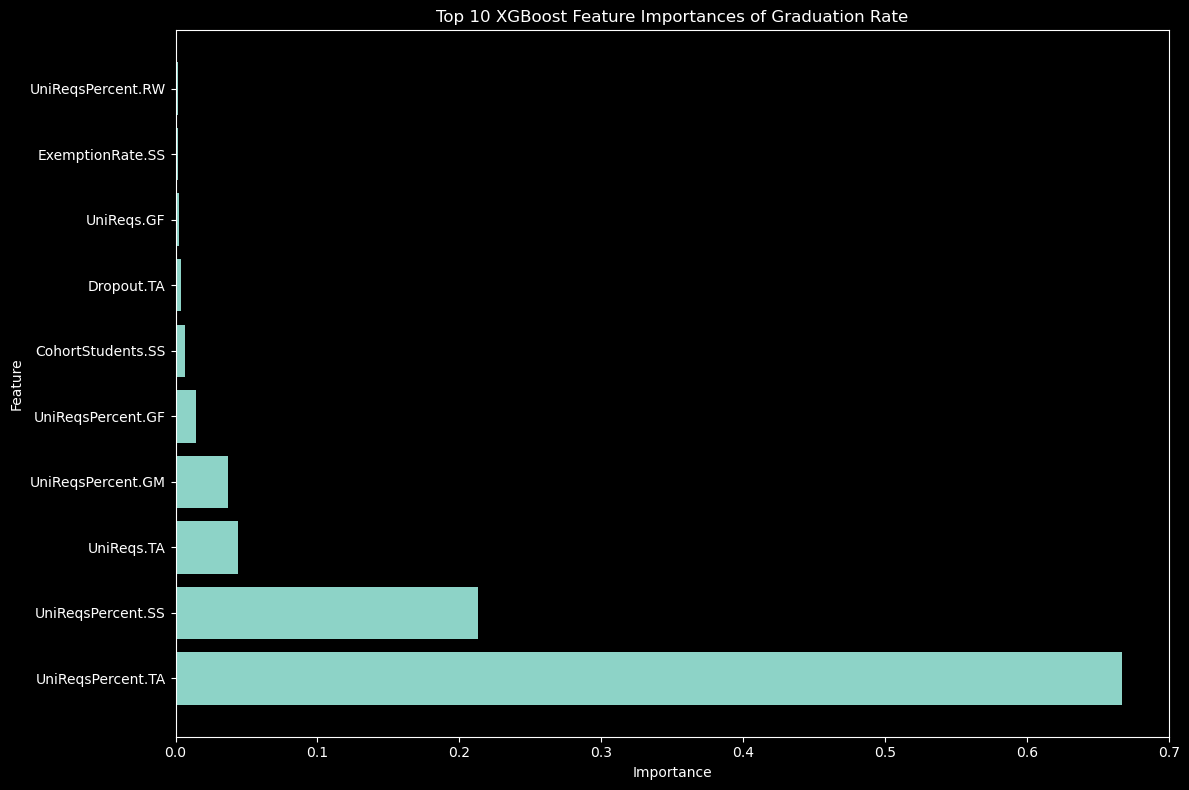

In [43]:
target_col = 'RegHSDiplomaRate.TA'

# Reset df
df = get_data_xgb()

# Drop columns that start with 'RegHSDiploma' but are not the target column
X = df.drop(columns=[col for col in df.columns if col.startswith('RegHSDiploma')])

# Remove rows where y is NaN or infinite or too large
mask = y.notna() & np.isfinite(y) & (np.abs(y) < 1e10)
X = X[mask]
y = y[mask]

xgb_regressor_uni = xgb.XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6,  
    subsample=0.8,  
    colsample_bytree=0.8, 
    missing=np.nan, 
    random_state=42
)

xgb_regressor_uni.fit(X, y)

# Get feature importances
importances_uni = xgb_regressor_uni.feature_importances_
feature_names_uni = X.columns
indices_uni = np.argsort(importances_uni)[::-1]

print("Feature ranking:")
for f in range(len(feature_names_uni)):
    print(f"{f + 1}. {feature_names_uni[indices_uni[f]]} ({importances_uni[indices_uni[f]]})")

# Plot top 10 feature importances for Graduation Rate
top_n = 10
top_indices = indices_uni[:top_n]
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), importances_uni[top_indices], align='center')
plt.yticks(range(top_n), feature_names_uni[top_indices])
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.title("Top 10 XGBoost Feature Importances of Graduation Rate")
plt.tight_layout()
plt.show()

### Model Validation

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the XGBoost model
xgb_regressor_uni.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor_uni.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"R^2 Score: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

R^2 Score: 0.9999779486153115
Mean Squared Error: 0.021786456316679345
Root Mean Squared Error: 0.1476023587774916
Mean Absolute Error: 0.08236611146458246


### Residuals

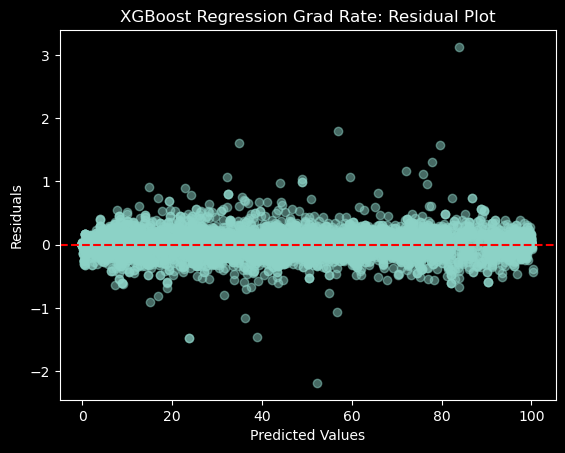

In [45]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost Regression Grad Rate: Residual Plot")
plt.show()

### Actual vs. Predicted

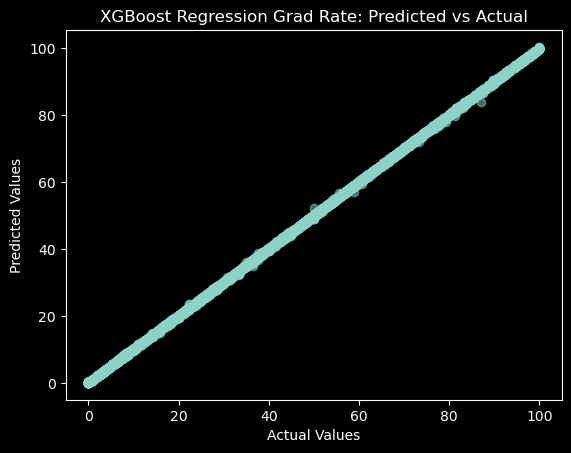

In [46]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost Regression Grad Rate: Predicted vs Actual")
plt.show()

In [47]:
con.close()